# Imports

In [1]:
pip install -U tensorflow-addons

In [2]:
import random
import datetime
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa

from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.utils import np_utils

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras import datasets, layers, models

# Hyperparameters Setup

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
NUM_CLASSES = 10

CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Model Setup

In [4]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [16]:
# images generator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
    )

train_gen.fit(X_train)
train_set = train_gen.flow(
    X_train, 
    Y_train, 
    batch_size = BATCH_SIZE)

valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
valid_set = valid_gen.flow(
    X_test, 
    Y_test, 
    batch_size = BATCH_SIZE)

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

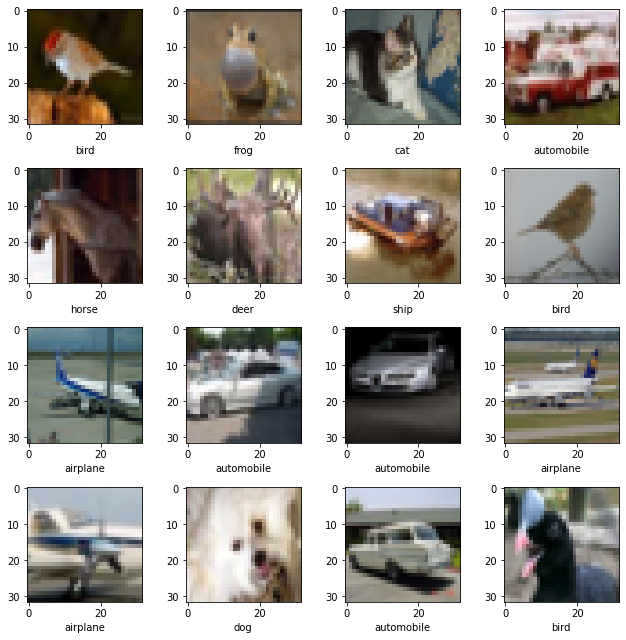

In [6]:
images, labels = next(valid_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img)
    idx = np.take(np.where(label == 1), 0)
    ax.set_xlabel(CLASSES[idx])
    ax.axis('on')
plt.tight_layout()
plt.show()

In [17]:
# create base model
base_model = tf.keras.applications.VGG16(
    input_shape = (32, 32, 3),
    include_top = False,
    weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# add dense layers to CNN
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 512, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units = 10, activation = 'softmax')
    ],
    name = 'model')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
# compile classifier
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
    metrics = ['accuracy']
)

In [21]:
# train the model
history = model.fit(
    train_set,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs = NUM_EPOCHS,
    validation_data = valid_set,
    validation_steps = STEP_SIZE_VALID
)

Epoch 1/20
1562/1562 [==============================] - 19s 12ms/step - loss: 1.3796 - accuracy: 0.5144 - val_loss: 1.2378 - val_accuracy: 0.5640
Epoch 2/20
1562/1562 [==============================] - 18s 11ms/step - loss: 1.2054 - accuracy: 0.5781 - val_loss: 1.1920 - val_accuracy: 0.5782
Epoch 3/20
1562/1562 [==============================] - 18s 11ms/step - loss: 1.1492 - accuracy: 0.5970 - val_loss: 1.1664 - val_accuracy: 0.5901
Epoch 4/20
1562/1562 [==============================] - 18s 11ms/step - loss: 1.1111 - accuracy: 0.6105 - val_loss: 1.1563 - val_accuracy: 0.5945
Epoch 5/20
1562/1562 [==============================] - 18s 11ms/step - loss: 1.0743 - accuracy: 0.6229 - val_loss: 1.1254 - val_accuracy: 0.6040
Epoch 6/20
1562/1562 [==============================] - 18s 11ms/step - loss: 1.0459 - accuracy: 0.6317 - val_loss: 1.1097 - val_accuracy: 0.6104
Epoch 7/20
1562/1562 [==============================] - 18s 11ms/step - loss: 1.0142 - accuracy: 0.6435 - val_loss: 1.1046 -

In [23]:
# evaluate accuracy and loss
(eval_loss, eval_accuracy) = model.evaluate(valid_set, batch_size = BATCH_SIZE, verbose = 1)

313/313 [==============================] - 3s 10ms/step - loss: 1.1587 - accuracy: 0.6219


In [24]:
# show results
print('Evaluate:')
print('---------------')
print("accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("loss: {}".format(eval_loss)) 

Evaluate:
---------------
accuracy: 62.19%
loss: 1.1587411165237427


Classification Report
              precision    recall  f1-score   support

           0       0.37      0.73      0.49      1000
           1       0.24      0.69      0.35      1000
           2       0.42      0.18      0.25      1000
           3       0.27      0.27      0.27      1000
           4       0.72      0.02      0.04      1000
           5       0.42      0.30      0.35      1000
           6       0.63      0.10      0.17      1000
           7       0.46      0.25      0.33      1000
           8       0.48      0.29      0.36      1000
           9       0.33      0.56      0.42      1000

    accuracy                           0.34     10000
   macro avg       0.43      0.34      0.30     10000
weighted avg       0.43      0.34      0.30     10000

Confusion Matrix


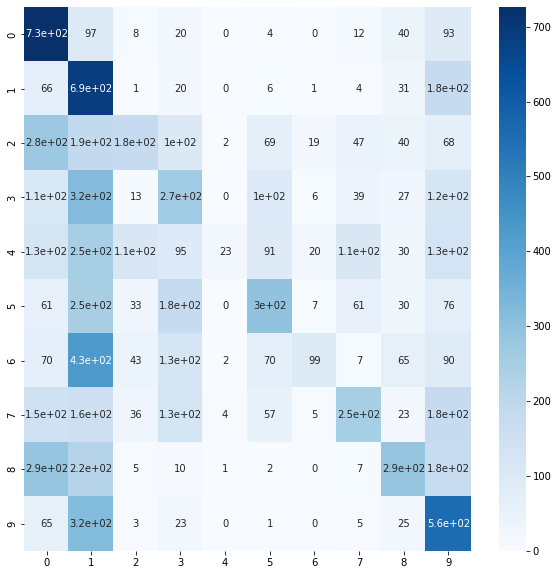

In [31]:
# predict classes from test dataset
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(y_test, y_pred))

print('Confusion Matrix')
confusionmatrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)